## Bayesian Ordinary Differential Equations

Let's perform inference with models of the sort,

$$\mathrm{d}/\mathrm{d}t \, x = f(x, \theta, t)$$ where $x \in \mathbb{R}^n$, $f: \mathbb{R}^n \times \mathcal{X} \times \mathbb{R} \to \mathbb{R}$.

In [1]:

from jax.config import config

config.update("jax_enable_x64", True)

try:
    import diffrax
except ImportError:
    print("You must `pip install diffrax` first.")
    raise

from diffrax import diffeqsolve, ODETerm


import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic, maximum_a_posteriori_point, evaluate_map_estimate
from jax import random
from jax import numpy as jnp
import pylab as plt

/home/albert/miniconda3/envs/jax_py/lib/python3.10/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
INFO[2023-08-01 20:55:56,367]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAlloc

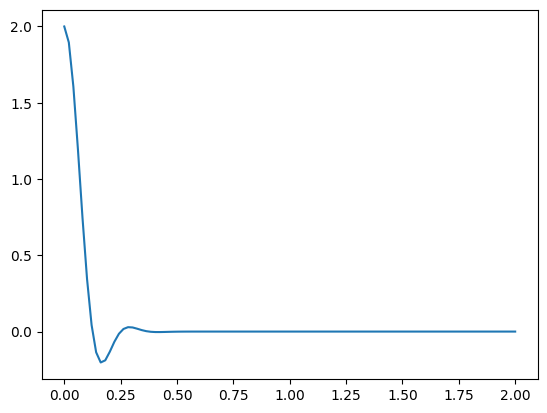

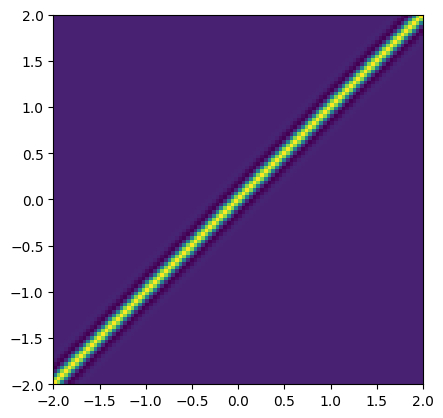

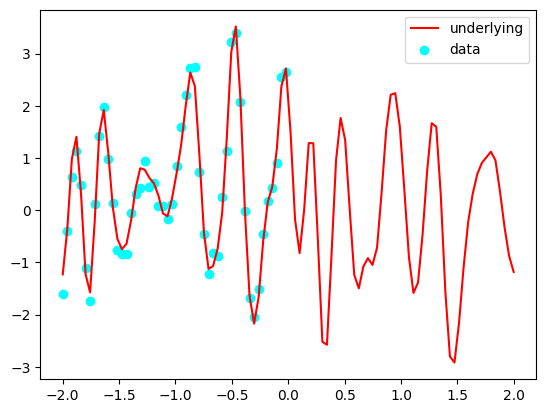

In [2]:
N = 100
M = N // 2
Xstar = jnp.linspace(-2., 2., N)[:, None]
X = Xstar[:M]

true_uncert = 0.2

spectral_params_true = dict(
    logits=jnp.asarray([0., 0.]),
    locs=jnp.asarray([1. / 1, 1. / 0.5]),
    scales=jnp.asarray([1. / 4., 1 / 0.8])
)
prior_cov = tfpk.SpectralMixture(**spectral_params_true).matrix(Xstar, Xstar) + 1e-12 * jnp.eye(N)
tfpk.SpectralMixture

v = jnp.linspace(0., 2., 100)
kern = tfpk.SpectralMixture(**spectral_params_true).matrix(jnp.zeros((1, 1)), v[:, None])
plt.plot(v, kern[0, :])
plt.show()

plt.imshow(prior_cov, origin='lower', extent=(Xstar.min(), Xstar.max(), Xstar.min(), Xstar.max()))
plt.show()

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,))
Y_obs = Y[:M] + true_uncert * random.normal(random.PRNGKey(1), shape=(M,))
# Y = jnp.cos(jnp.pi*2. * X[:,0]/2) + jnp.exp(- X[:,0]/2) * jnp.sin(jnp.pi*2. * X[:,0]/3)


plt.plot(Xstar[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.legend()
plt.show()


-1.5961004237394143 0.0
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float64[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[100])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
(50,) (50,)


INFO[2023-08-01 20:56:02,397]: Sanity check...
INFO[2023-08-01 20:56:02,645]: Sanity check passed


Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=3/0)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=3/0)>
(50,) (50,)
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=4/1)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=4/1)>
(50,) (50,)
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=4/1)> Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=4/1)>
(50,) (50,)
-1.5961004237394143 Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
  val = Array([0.00927862, 0.0024775 , 0.01533703, ..., 1.31518239, 1.313937  ,
       1.30910708], dtype=float64)
  batch_dim = 0
-1.5961004237394143 Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)> with
  val = Array([0.00927862, 0.0024775 , 0.01533703, ..., 1.31518239, 1.313937  ,
       1.30910708], dtype=float64)
  batch_dim = 0
--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 95795
# samples: 2280
# slices: 16200.0
# slices / acceptan

WARNING[2023-08-01 20:56:30,660]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


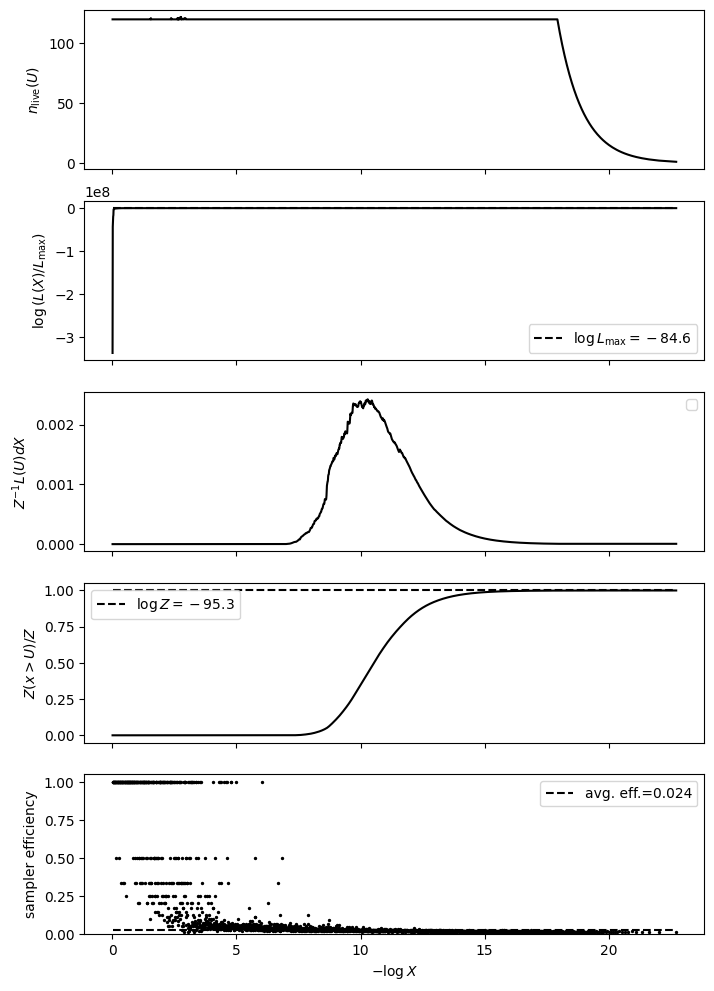

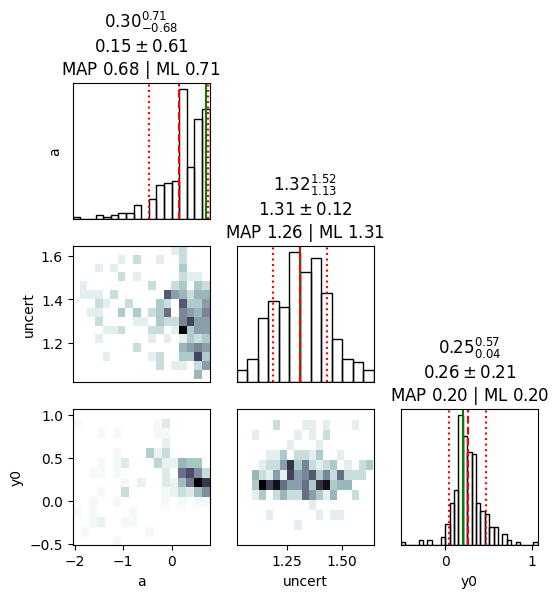

In [3]:


from diffrax import SaveAt, Tsit5
from jaxns import Prior, Model, TerminationCondition, ApproximateNestedSampler

kernel = tfpk.SpectralMixture


def log_normal(x, mean, uncert):
    log_det = x.size * jnp.log(uncert)
    print(x.shape, mean.shape)
    dx = (x - mean) / uncert
    maha = dx @ dx
    log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
    return log_likelihood


def f(t, y, args):
    out = args['a'] * y
    return out.reshape(y.shape)


def log_likelihood(uncert, f_args, y0):
    term = ODETerm(f)
    solver = Tsit5()
    t0 = X[0, 0]
    t1 = X[-1, 0]
    dt0 = 0.1 * (X[1, 0] - X[0, 0])
    saveat = SaveAt(ts=X[:,0])
    Y_sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=f_args, saveat=saveat)
    return log_normal(x=Y_obs, mean=Y_sol.ys, uncert=uncert)


def prior_model():
    a = yield Prior(tfpd.Normal(0., 1.), name='a')
    uncert = yield Prior(tfpd.Exponential(1./0.2), name='uncert')
    y0 = yield Prior(tfpd.Normal(Y_obs[0], uncert), name='y0')
    f_args = dict(a=a)
    return uncert, f_args, y0

model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# Create the nested sampler class. In this case without any tuning.
exact_ns = ApproximateNestedSampler(model=model,
                                    num_live_points=model.U_ndims * 40,
                                    max_samples=1e6,
                                    num_parallel_samplers=1)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-5))
results = exact_ns.to_results(state, termination_reason)

exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)


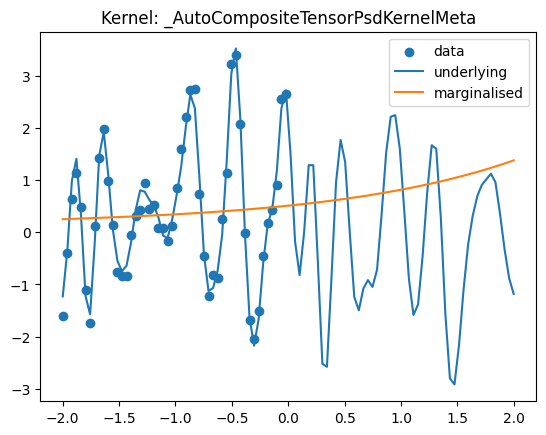

In [6]:
def predict_f_fn(a, y0):
    f_args = dict(a=a)
    term = ODETerm(f)
    solver = Tsit5()
    t0 = Xstar[0, 0]
    t1 = Xstar[-1, 0]
    dt0 = 0.1 * (Xstar[1, 0] - Xstar[0, 0])
    saveat = SaveAt(ts=Xstar[:,0])
    Y_sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=f_args, saveat=saveat)
    return Y_sol.ys


predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                results.ESS, predict_f_fn)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(Xstar[:, 0], Y, label='underlying')
plt.plot(Xstar[:, 0], predict_f, label='marginalised')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()

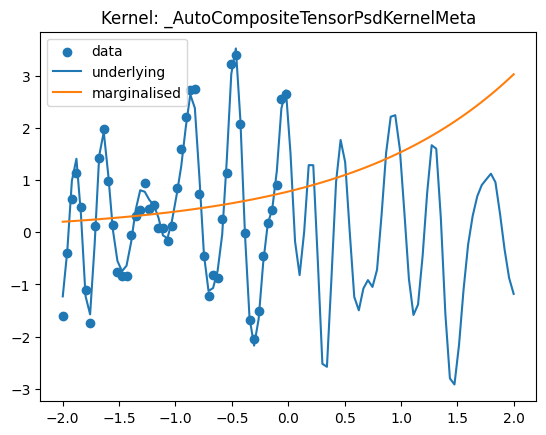

In [7]:
map_sample = maximum_a_posteriori_point(results)

predict_f = evaluate_map_estimate(results, predict_f_fn)


plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(Xstar[:, 0], Y, label='underlying')
plt.plot(Xstar[:, 0], predict_f, label='marginalised')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()